In [249]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from scipy.stats import wasserstein_distance
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import bernoulli
from scipy.stats import nbinom

In [4]:
def ideal_distribution(N):
    """ Create the ideal soliton distribution. 
    In practice, this distribution gives not the best results
    Cf. https://en.wikipedia.org/wiki/Soliton_distribution
    """
    EPSILON = 10e-8

    probabilities = [0, 1 / N]
    probabilities += [1 / (k * (k - 1)) for k in range(2, N+1)]
    probabilities_sum = sum(probabilities)

    assert probabilities_sum >= 1 - EPSILON and probabilities_sum <= 1 + EPSILON, "The ideal distribution should be standardized"
    return probabilities

N = 100
idd = ideal_distribution(N)
#_=plt.hist(idd, bins='auto', range=(0,1/N))

In [5]:
star = 5

def poi_pmf(k, k_star=star, lmb=1):
    if k == k_star:
        #print("k_star")
        return 0
    elif k == k_star - 1:
        #print("k_star - 1")
        return poisson.pmf(k,lmb)+poisson.pmf(k_star,lmb)
    else:
        return poisson.pmf(k,lmb)
    
def get_poisson_pmf_array(n_max, poisson_param):
    poisson_arr = []
    
    for k in range(0,n_max):
        poisson_pmf_k = poisson.pmf(k,poisson_param)#poisson_param**k/(np.exp(poisson_param)*np.math.factorial(k))
        poisson_arr.append(poisson_pmf_k)
        
    return poisson_arr

def get_binom_pmf_array(n, p=0):
    if p == 0:
        p = 1/n
        
    binom_arr = []
    
    for k in range(0,n):
        binom_pmf_k = binom.pmf(k, n, p)
        binom_arr.append(binom_pmf_k)
        
    return binom_arr

def binom_func(j,k,n):
    return scipy.special.binom(j,k) * (1/n)**k * (1-1/n)**(j-k)

def pmf_of_sum(n, k):
    if n == 1:
        return poi_pmf(k)
    
    return sum(pmf_of_sum(n-1,i)*poi_pmf(k-i) for i in range(0, k))

def get_thinning_pmf_array(n, rv=""):
    thinning_arr = []
    
    for k in range(0,n):
        thinning_pmf_k = pmf_of_sum(n, k)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr


In [237]:
def display_wasserstein_distance_info(w_range, n_range, text=""):

    print(f"W_1({text},Poisson) is monotonically decreasing: {is_monot_decreasing(w_range)}")
    print(f"W_1({text},Poisson) is monotonically increasing: {is_monot_increasing(w_range)}")
    print()
    
    plt.figure(figsize=(10,5))
    
    plt.plot(n_range, w_range, c="black")
    plt.title(f"W_1({text},Poisson)")
    plt.show()
    
def plot_pmf(x, y, title=""):
    plt.plot(x, y, 'ro')
    plt.title(title)
    plt.show()
    
def get_relative_entropy(p1, p2=[]):
    if np.size(p2) == 0:
        return scipy.stats.entropy(p1)
    
    return scipy.stats.entropy(p1, p2)

def is_monot_increasing(arr):
    return all(float(fst) <= float(snd) for fst, snd in zip(arr, arr[1:]))

def is_monot_decreasing(arr):
    return all(float(fst) >= float(snd) for fst, snd in zip(arr, arr[1:]))

In [7]:
uniform_const = "Uniform"
soliton_const = "Soliton"
geometric_const = "Geometric"
binomial_const = "Binomial"
poisson_one_const = "Poisson(1)"
poisson_onehalf_const = "Poisson(1/2)"

poisson_with_hole_const = "Poisson with a hole in the support"
binomial_with_hole_const = "Binomial with a hole in the support"
uniform_with_hole_const = "Uniform with a hole in the support"

    
def thinning_pmf(n, k, rv):
    
    #c = (np.exp(-1/n)*(1/n)**k)/np.math.factorial(k) #with n=1, Y\sim Poisson(1). Does not make sense since we are interested in increasing n
    
    if rv == poisson_one_const:
        c = poisson.pmf(k,1)#1/(np.exp(1)*np.math.factorial(k)) #with Y_i\sim Poisson(1), i=1,...,n
        #print(c)
        #print(poisson.pmf(k,1))
        #print()
    
    if rv == poisson_onehalf_const:
        c = 0.5**k/(np.exp(0.5)*np.math.factorial(k)) #with Y_i\sim Poisson(0.5), i=1,...,n
    
    if rv == geometric_const:
        l = 0.5/n
        c = 1/(1+l)*(l/(1+l))**k #geometric
    
    if rv == binomial_const:
        c = binom.pmf(k, n, 1/n) #binomial
    
    if rv == soliton_const:
        # soliton distribution (https://en.wikipedia.org/wiki/Soliton_distribution)
        if k == 1:
            c = 1/n
        else:
            c = 1/(k*(k-1)) #k should be >0
        
    if rv == uniform_const:
        c = 1/n #uniform
    
    
    k_star = 5
    
    if rv == uniform_with_hole_const:
        if k < k_star:
            c = 1/(k_star)/2
        elif k == k_star:
            c = 0
        else:
            c = 1/(n-k_star-1)/2
                    
    if rv == poisson_with_hole_const:
        lmb = 1
        
        if k == k_star:
            c = 0
        elif k == k_star - 1:
            c = poisson.pmf(k,lmb) + poisson.pmf(k_star,lmb)#np.exp(-lmb)*lmb**k/np.math.factorial(k)+np.exp(-lmb)*lmb**k_star/np.math.factorial(k_star)
        else:
            c = poisson.pmf(k,lmb)#np.exp(-lmb)*lmb**k/np.math.factorial(k)
    
    if rv == binomial_with_hole_const:
        p = 1/n
        
        if k == k_star:
            c = 0
        elif k == k_star - 1:
            c = binom.pmf(k, n, p) + binom.pmf(k_star, n, p)
        else:
            c = binom.pmf(k, n, p)
        
    return c
    #print(c)
  

W_1(Binomial,Poisson) is monotonically decreasing: True
W_1(Binomial,Poisson) is monotonically increasing: False



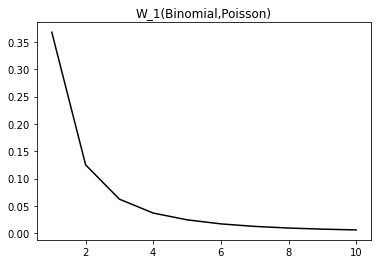

thinning pmf sum=0.36787944117144233, n=1
thinning pmf sum=0.1353352832366127, n=2
thinning pmf sum=0.04978706836786395, n=3
thinning pmf sum=0.018315638888734186, n=4
thinning pmf sum=0.00673794699908547, n=5
thinning pmf sum=0.0024787521766663594, n=6
thinning pmf sum=0.0009118819655545166, n=7
thinning pmf sum=0.00033546262790251196, n=8
thinning pmf sum=0.0001234098040866796, n=9
thinning pmf sum=4.539992976248487e-05, n=10
H(Binomial|Poisson) is monotonically decreasing: False (should always be true)
[0.0, 0.6931471805599453, 1.6094379124341003, 2.772588722239781, 4.174387269895637, 5.786897381366708, 7.579167967396076, 9.525151111816216, 11.604601777542019, 13.801827368655985]

H(Binomial) is monotonically increasing: True (should be true only in ULC case)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

H(Binomial)_10=0.0, H(Poisson(1))=1.3048404554454895
H(Binomial|Poisson)=13.801827368655985


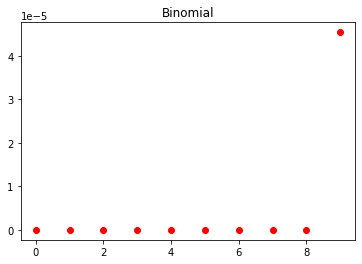

W_1(Thinning(Binomial),Poisson) is monotonically decreasing: False
W_1(Thinning(Binomial),Poisson) is monotonically increasing: False



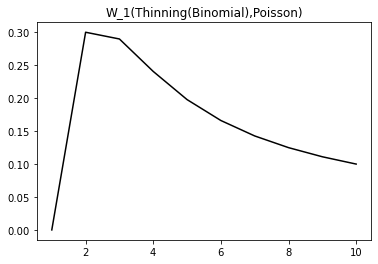

In [8]:
# Init
n_min = 1
n_max = 10
n_step = 1

poisson_param = 1

n_range = range(n_min,n_max+n_step,n_step)
k_range = range(n_min,n_max)

poisson_arr = get_poisson_pmf_array(n_max, poisson_param)
    
#print(f"poisson pmf sum={sum(poisson_arr)}")

# Law of small numbers
w_range = []
for n in n_range:
    binom_arr = get_binom_pmf_array(n, 1/n)
    
    #print(f"binom pmf sum={sum(binom_arr)}, n={n}")
    
    w = wasserstein_distance(poisson_arr[:n], binom_arr)
    w_range.append(w)
    #print(w)
    
#print(np.size(poisson_arr), np.size(binom_arr))
    
display_wasserstein_distance_info(w_range, n_range, "Binomial")

# Law of thin numbers
w_range = []

entropy = []
rel_entropy = []

thinning_rv = binomial_const

for n in n_range:
    thinning_arr = get_thinning_pmf_array(n, thinning_rv)
    
    print(f"thinning pmf sum={sum(thinning_arr)}, n={n}")

    w = wasserstein_distance(poisson_arr[:n], thinning_arr)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(thinning_arr, poisson_arr[:n]))
    entropy.append(get_relative_entropy(thinning_arr))


print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(poisson_arr)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")

plot_pmf(range(0,n), thinning_arr, title=thinning_rv)
#print(np.size(poisson_arr), np.size(thinning_arr))

    
display_wasserstein_distance_info(w_range, n_range, f"Thinning({thinning_rv})")


In [9]:
n_step = 100

for n in range(1,10):
    sum_index_rv_new = bernoulli.rvs(0.5, size=n_step)
    sum_index_new = sum(sum_index_rv_new)
    
    sum_index = sum_index + sum_index_new
    
    thinning_arr = bernoulli.rvs(1/sum_index, size=sum_index)
    poisson_arr_new = poisson.rvs(mu=poisson_param, size=sum_index_new)

    np.append(poisson_arr, poisson_arr_new)
    
    w = wasserstein_distance(thinning_arr, poisson_arr)
    #print(w)

NameError: name 'sum_index' is not defined

In [10]:
print(wasserstein_distance(np.arange(3), np.arange(3), [1,0,0],[0,0.5,0.5]))

1.5


In [11]:
sum_index_rv = bernoulli.rvs(0.5, size=n_initial)
sum_index = sum(sum_index_rv)

bernoulli_arr = bernoulli.rvs(1/sum_index, size=sum_index)
poisson_arr = poisson.rvs(mu=poisson_param, size=sum_index)

n_step = 1000

for n in range(1,10):

    sum_index = sum_index + n_step
    
    bernoulli_arr = bernoulli.rvs(1/sum_index, size=sum_index)
    poisson_arr_new = poisson.rvs(mu=poisson_param, size=n_step)

    np.append(poisson_arr, poisson_arr_new)
    
    w = wasserstein_distance(bernoulli_arr, poisson_arr)
    print(w)

NameError: name 'n_initial' is not defined

In [12]:
from mpmath import nsum, exp, inf

k = 10
n = 100

#s = nsum(lambda j: np.math.factorial(j+1)*(1-1/n)**(j-k)/np.math.factorial(j-k), [k, inf])

In [13]:
def thinning_convolution(n,k):
    if n == 1:
        return thinning_pmf(n,k)
    
    return sum(thinning_convolution(n-1,i)*poi_pmf(k-i,k_star) for i in range(1, k))

In [362]:
 def pmf_of_sum_poi(n, k):
    if n == 1:
        return poi_pmf(k)
    
    return sum(pmf_of_sum_poi(n-1,i)*poi_pmf(k-i,k_star) for i in range(1, k))

def thinning_pmf(n, k, l):
    #print(n)
    
    #return sum(pmf_of_sum_poi(n,j) * binom_func(j,k,1/n) for j in range(k, k+10))
    #return sum(poisson.pmf(j,n) * binom.pmf(k,j,1/n) for j in range(k, k+300)) # does not work
    return sum(binom_func(n,j,0.5) * binom_func(j,k,1/n) for j in range(k, n+1)) # works
    #return sum(np.exp(-n)*n**j/np.math.factorial(j) * binom_func(j,k,1/n) for j in range(k, k+100))
    
    #return sum(pmf_of_sum_bin(n,j,l) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    
def get_poisson_pmf_array(K, poisson_param):
    poisson_arr = []
    
    for k in range(0,K+1):
        poisson_pmf_k = poisson.pmf(k,poisson_param)#poisson_param**k/(np.exp(poisson_param)*np.math.factorial(k))
        poisson_arr.append(poisson_pmf_k)
        
    return poisson_arr

In [426]:
k_star = 3

def uniform_pmf(b,k):
    if k < 0:
        return 0
    
    return 1/(b+1)
    
def soliton_pmf(n, k):
    if k == 0:
        return 0
    
    if k == 1:
        return 1/n
    else:
        return 1/(k*(k-1))
    
def binom_func(n,m,p):
    #print(j,k,p)
    #print(scipy.special.binom(j,k) * (p**k) * (1-p)**(j-k))
    #print()

    s = scipy.special.binom(n,m) * (p**m) * (1-p)**(n-m)
    return s
    
def get_binomial_pmf_array(K, p):
    bin_arr = []
    
    for k in range(0,K+1):
        bin_pmf_k = binom_func(K,k,p)#binom.pmf(k,n,p)
        bin_arr.append(bin_pmf_k)
        
    return bin_arr

def bin_pmf(n, m, p, k_star=2):
    if m == k_star: #or m == n-k_star:
        return 0
    elif m == k_star + 1:
        return binom_func(n,m,p) + binom_func(n,k_star,p) #binom.pmf(k,j,p) + binom.pmf(k_star,j,p)
    #elif m == n - k_star - 1:
    #    return binom_func(n,m,p) + binom_func(n,n-k_star,p)
    else:
        return binom_func(n,m,p)#binom.pmf(k,j,p)
    #return binom_func(n,m,p) #binom.pmf(k,j,p)

def pmf_of_sum_bin(n, l, k, p=0.5):

    #print(n, l, k)
    #return binom_func(l*n,k,p)

    if n == 1:
        #return bin_pmf(l,k,p)
        #return soliton_pmf(l, k)
        return uniform_pmf(l,k)
    
    #return sum(pmf_of_sum_bin(n-1,l*n+1,i,p)*soliton_pmf(l*n+1,k-i) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,p)*bin_pmf(l,k-i,p) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,p)*uniform_pmf(k) for i in range(0, k+1))
    return sum(pmf_of_sum_bin(n-1,l,i,p)*uniform_pmf(l,k-i) for i in range(0, k+1))

from math import prod

def q_binom_coef(n,m,q):
    s = 1
    for i in range(0,m):
        s *= (1-q**(n-i))/(1-q**(i+1))
        
    return s
    #return prod((1-q**(n-i))/(1-q**(i+1)) for i in range(0,m))

def thinning_pmf(n, k, l):
    #binom_func(l*n+1,j,0.5)
    return sum(1/(l*n+1) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(pmf_of_sum_bin(n,l,j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(nbinom.pmf(j,n,0.5) * binom_func(j,k,1/n) for j in range(k, l*n+1)) #sum of geom RV
    
def get_thinning_pmf_array(K,n,l):
    thinning_arr = []
    
    for k in range(0,K+1):
        thinning_pmf_k = thinning_pmf(n,k,l)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr
    

## Binomial distribution with a zero in the support -> Poisson distribution

0.9863047314016166
n=1, pmf sum=1.0


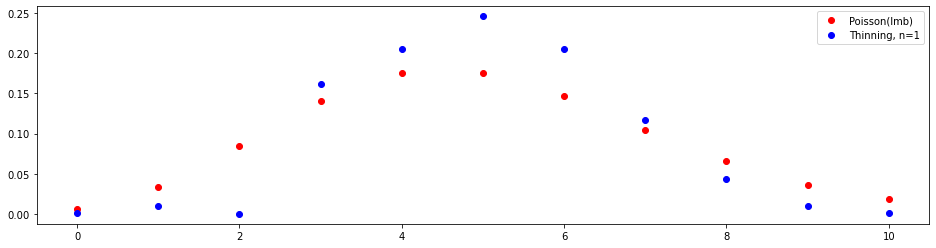

n=2, pmf sum=0.9960529758773191


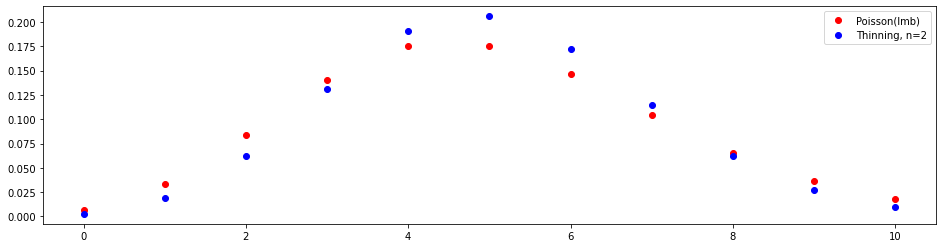

n=3, pmf sum=0.9931598328453229


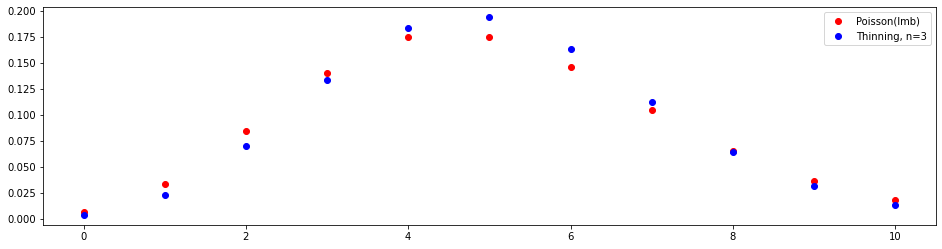

n=4, pmf sum=0.991449024722595


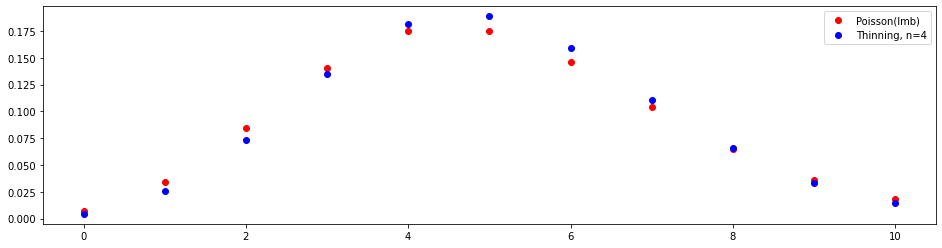

n=5, pmf sum=0.9903473757709623


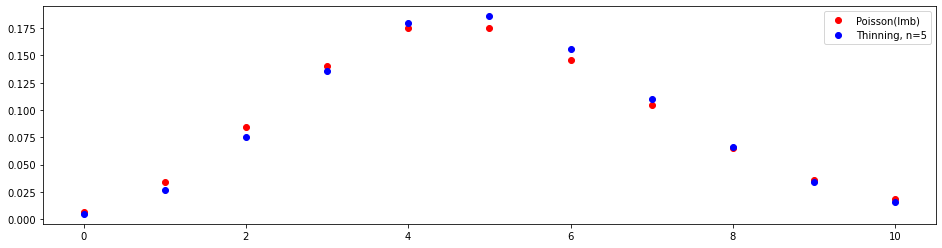

H(Binomial|Poisson) is monotonically decreasing: True (should always be true)
[0.15948190674221102, 0.018560023646749486, 0.007537589989867867, 0.004176440287999771, 0.002714435992127397]

H(Binomial) is monotonically increasing: True (should be true only in ULC case)
H(Binomial) is monotonically decreasing: False (should be true only in ULConvex case)
[1.7815374118678104, 2.0405154089929463, 2.0845136688986012, 2.1031570499573795, 2.1134166874399645]

H(Binomial)_5=2.1134166874399645, H(Poisson(1))=2.146692802738898
H(Binomial|Poisson)=0.002714435992127397

[0.033772067591617654, 0.013924121030641985, 0.008773729399382691, 0.006490889421955108, 0.005251513613495786]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



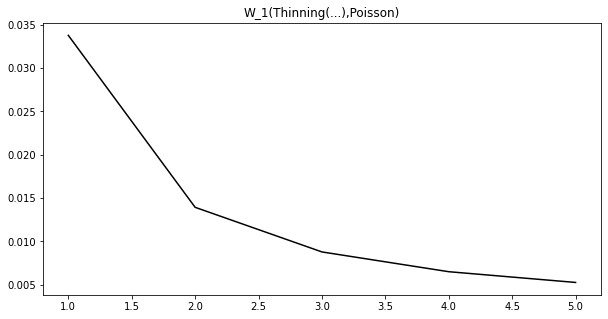

In [368]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 5
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label='Poisson(lmb)')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Binomial distribution with a zero in the support vs Binomial distribution

1.0
n=1, pmf sum=1.0


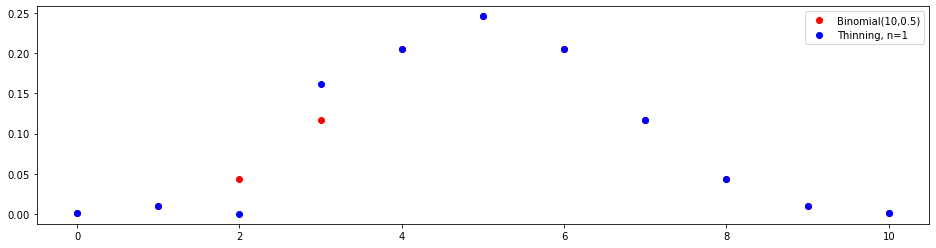

n=2, pmf sum=0.9960529758773191


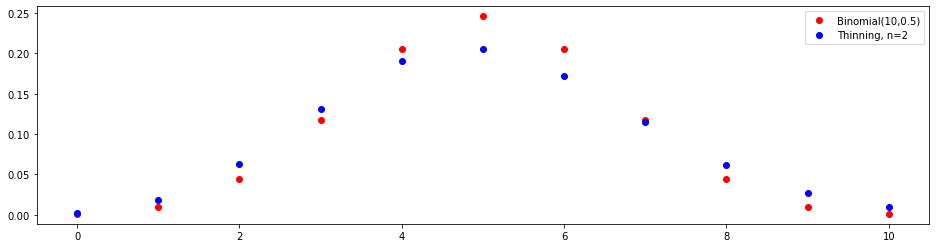

n=3, pmf sum=0.9931598328453229


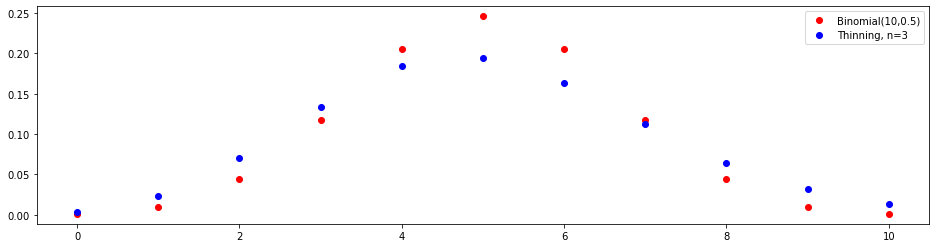

n=4, pmf sum=0.991449024722595


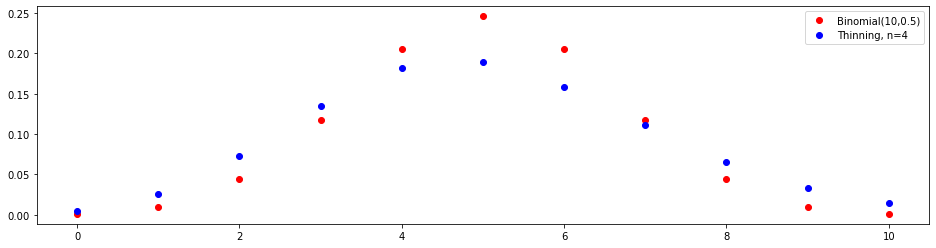

H(Binomial|Poisson) is monotonically decreasing: False (should always be true)
[0.05131334534624825, 0.042962593361911536, 0.07033556894070325, 0.08485487601192797]

H(Binomial) is monotonically increasing: True (should be true only in ULC case)
H(Binomial) is monotonically decreasing: False (should be true only in ULConvex case)
[1.7815374118678104, 2.0405154089929463, 2.0845136688986012, 2.1031570499573795]

H(Binomial)_4=2.1031570499573795, H(Poisson(1))=1.8759536052468004
H(Binomial|Poisson)=0.08485487601192797

[0.007990056818181818, 0.016073598072663033, 0.02122398970392233, 0.023549774336678146]

W_1(Thinning(...),Poisson) is monotonically decreasing: False
W_1(Thinning(...),Poisson) is monotonically increasing: True



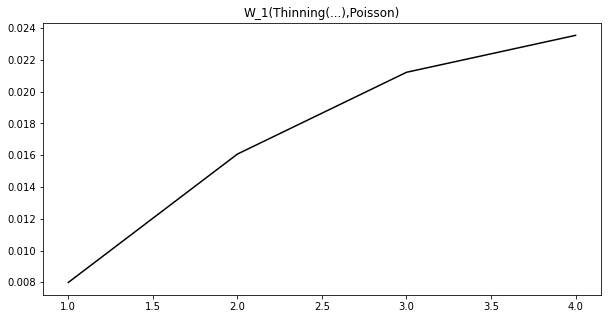

In [371]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 5
p1 = get_binomial_pmf_array(K, p)
p3 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label='Poisson(lmb)')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Geometric distribution -> Poisson distribution

0.9999999899522336
n=1, pmf sum=0.9995117187499999


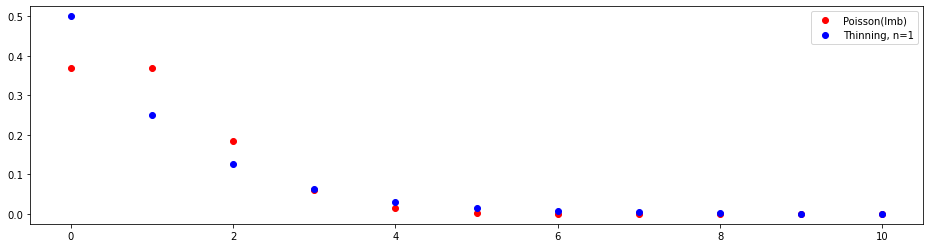

n=11, pmf sum=0.9999997850760606


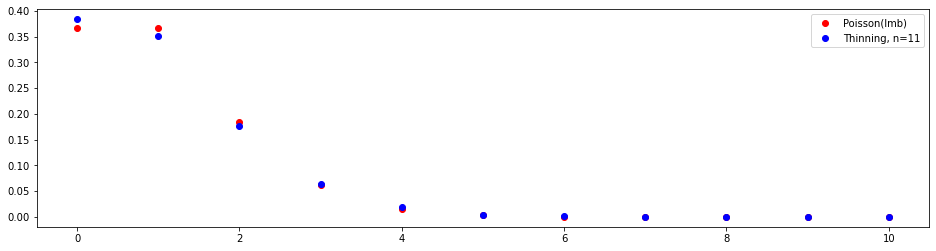

n=21, pmf sum=0.9999999379770498


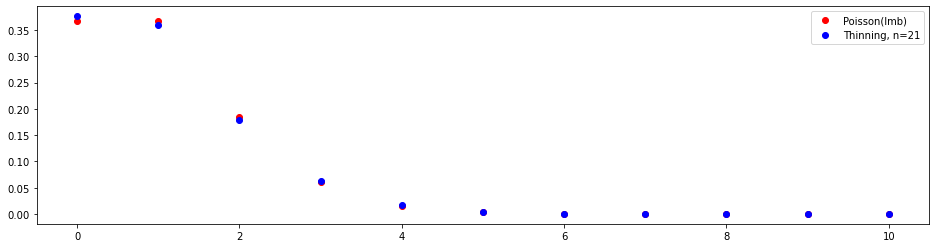

n=31, pmf sum=0.9999999632309221


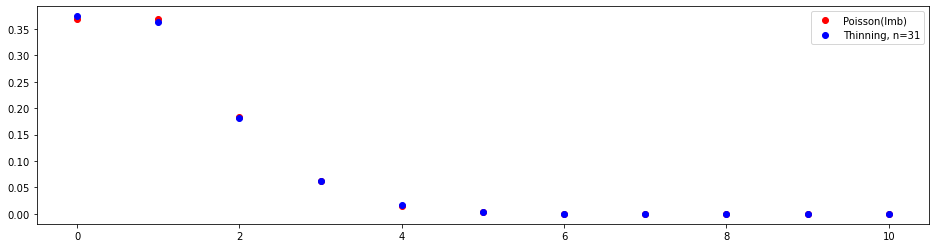

n=41, pmf sum=0.9999999724588988


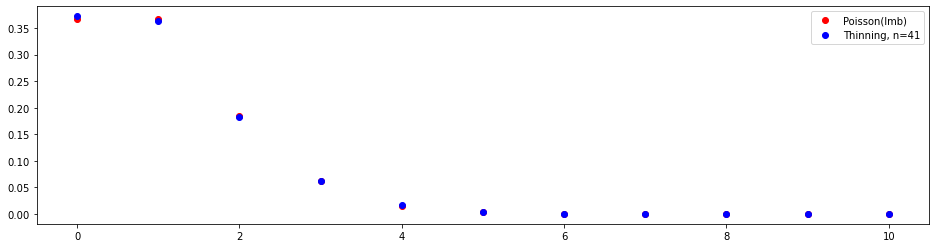

n=51, pmf sum=0.9999999770767787


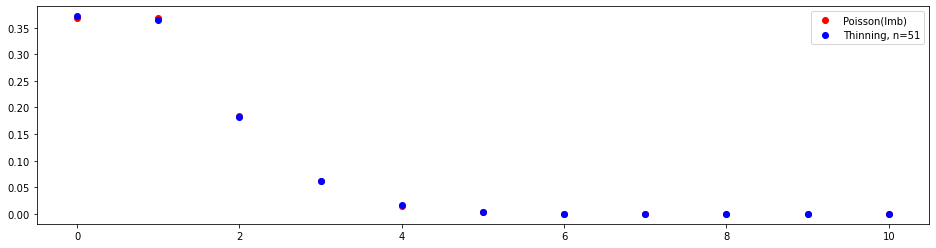

n=61, pmf sum=0.9999999798096295


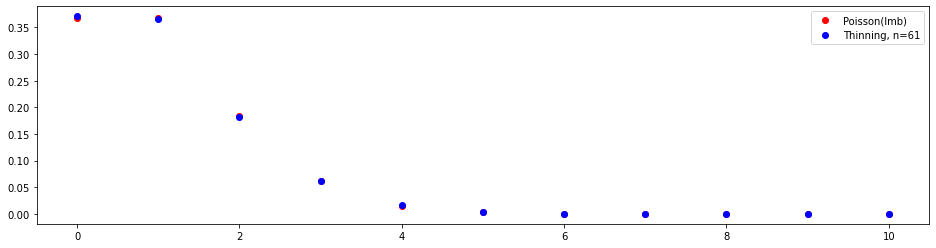

n=71, pmf sum=0.9999999816036257


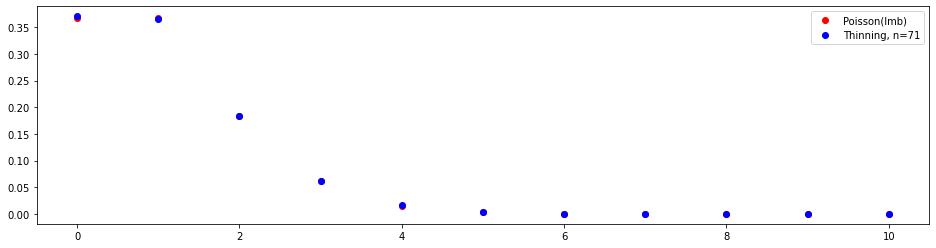

n=81, pmf sum=0.9999999828669054


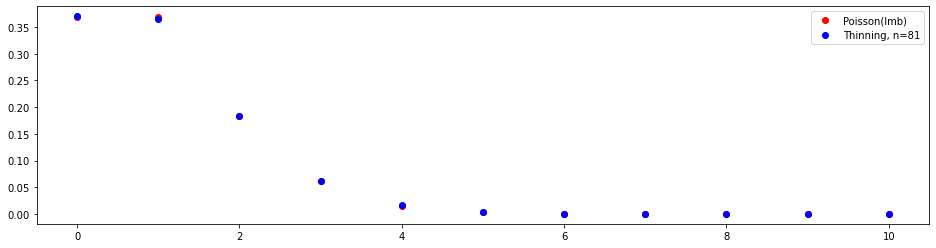

n=91, pmf sum=0.9999999838025709


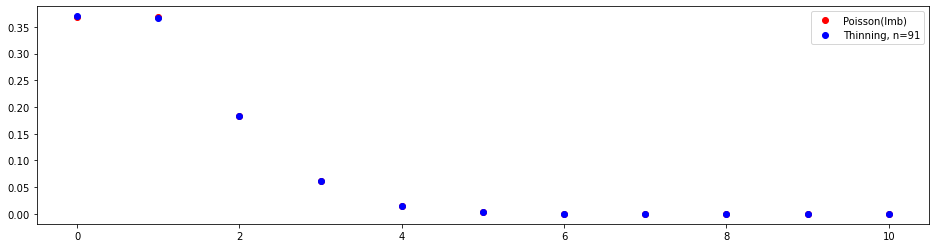

H(Binomial|Poisson) is monotonically decreasing: True (should always be true)
[0.11620012586532968, 0.0018932961664297884, 0.0005410555949533268, 0.0002519937086051594, 0.00014516934933584338, 9.426229482330116e-05, 6.609857366865238e-05, 4.890172265210023e-05, 3.763718423499626e-05, 2.9859843036026974e-05]

H(Binomial) is monotonically increasing: False (should be true only in ULC case)
H(Binomial) is monotonically decreasing: True (should be true only in ULConvex case)
[1.3820811833935656, 1.3241431494590903, 1.3154903631728638, 1.312191272257523, 1.310452446090547, 1.30937888246685, 1.3086501433858446, 1.30812309683822, 1.3077241934900388, 1.3074117671530154]

H(Binomial)_100=1.3074117671530154, H(Poisson(1))=1.304842057169971
H(Binomial|Poisson)=2.9859843036026974e-05

[0.03210455021019028, 0.0043319304177948485, 0.0023244334774841545, 0.0015884026385513323, 0.0012064045005622445, 0.0009725229029056276, 0.0008145999642243143, 0.0007008008957491954, 0.0006148999503496066, 0.00054775

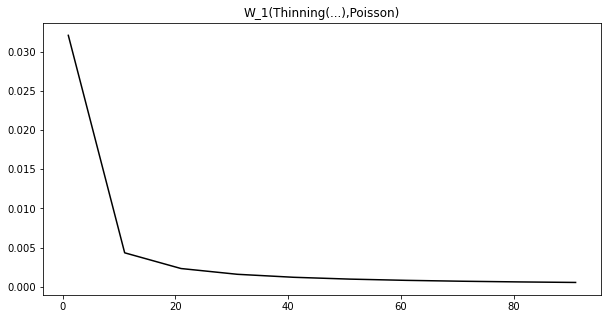

In [259]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
lmb = 1
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 100
n_step = 10
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label='Poisson(lmb)')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Binomial distribution -> Poisson distribution

0.9863047314016166
n=1, pmf sum=1.0


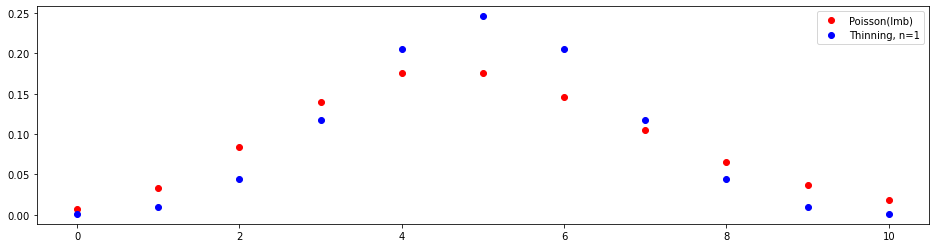

n=11, pmf sum=0.988329443631719


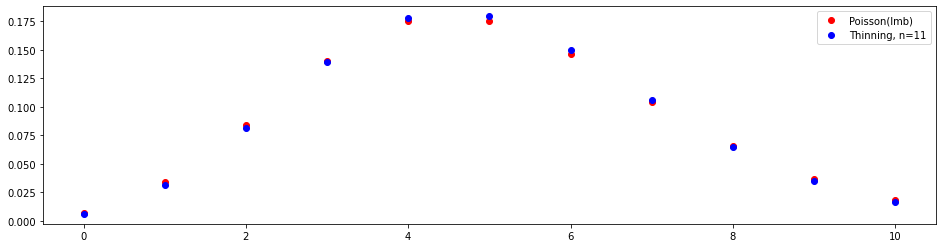

n=21, pmf sum=0.9873746384936806


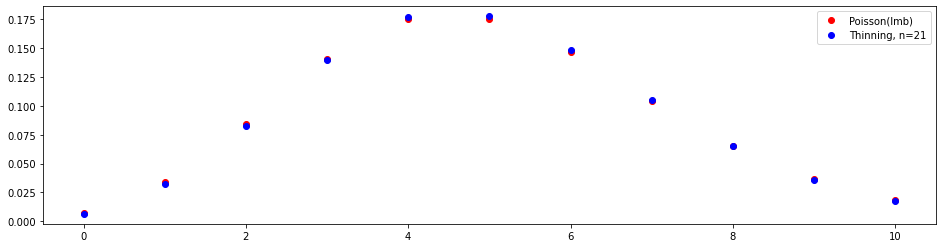

n=31, pmf sum=0.9870316314906742


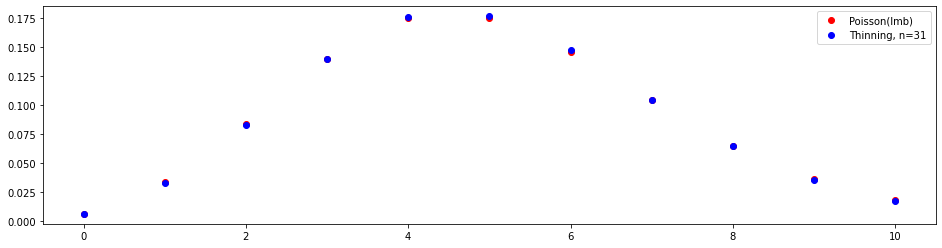

n=41, pmf sum=0.9868551432798108


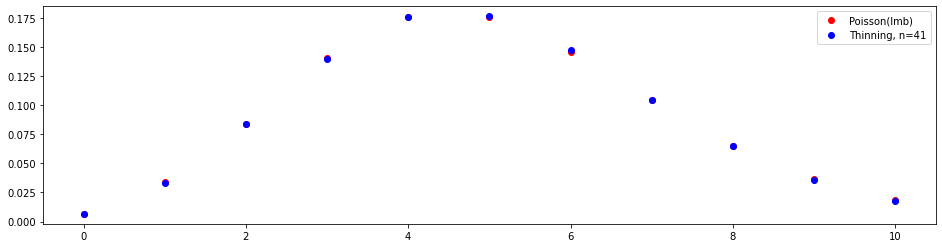

n=51, pmf sum=0.986747607715943


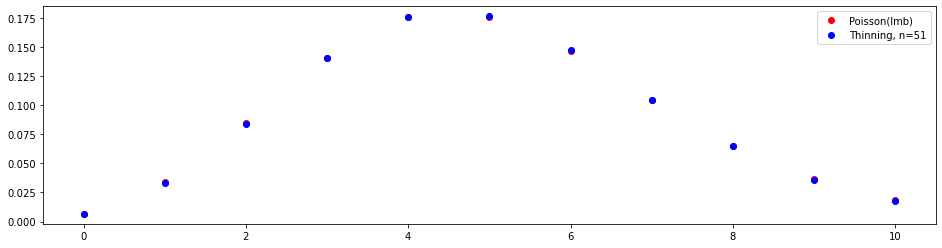

n=61, pmf sum=0.9866752215732334


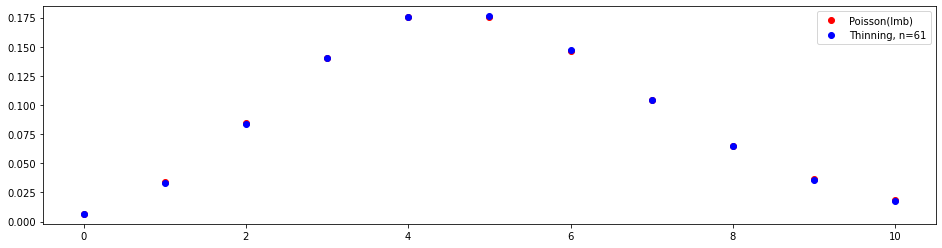

n=71, pmf sum=0.986623172770854


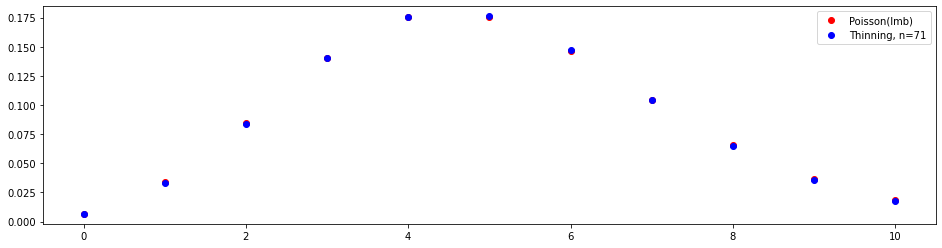

n=81, pmf sum=0.9865839464135951


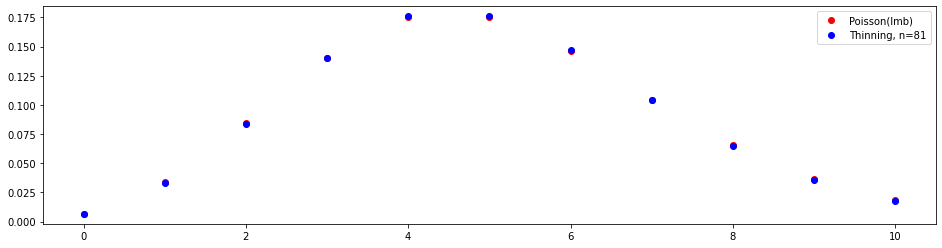

n=91, pmf sum=0.986553323951523


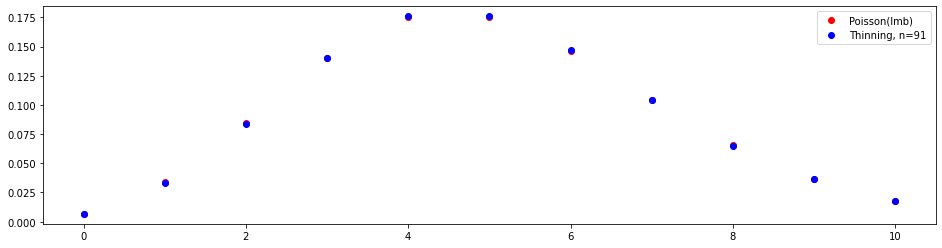

H(Binomial|Poisson) is monotonically decreasing: True (should always be true)
[0.08751410503262479, 0.00035604882367229604, 9.535717536698972e-05, 4.339194332066479e-05, 2.4700388152892265e-05, 1.5922246034809145e-05, 1.1110395090503845e-05, 8.19088261290869e-06, 6.287382238193655e-06, 4.977823340190056e-06]

H(Binomial) is monotonically increasing: True (should be true only in ULC case)
H(Binomial) is monotonically decreasing: False (should be true only in ULConvex case)
[1.8759536052468004, 2.1330809031922966, 2.1397153477155473, 2.142001789676846, 2.143159592697116, 2.143859010787938, 2.1443272794309562, 2.1446627369173075, 2.1449148679207983, 2.145111289449303]

H(Binomial)_100=2.145111289449303, H(Poisson(1))=2.146692802738898
H(Binomial|Poisson)=4.977823340190056e-06

[0.02999771910330502, 0.0018927978243779575, 0.0009770567072661654, 0.0006584838683149116, 0.0004965744923410483, 0.00039857273493180295, 0.0003328775343196834, 0.00028577445610917076, 0.00025034934990273854, 0.0002

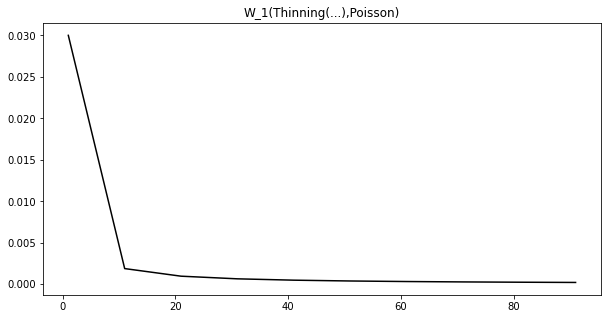

In [280]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
lmb = 5
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 100
n_step = 10
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label='Poisson(lmb)')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Uniform

0.9863047314016166
n=1, pmf sum=1.0000000000000002


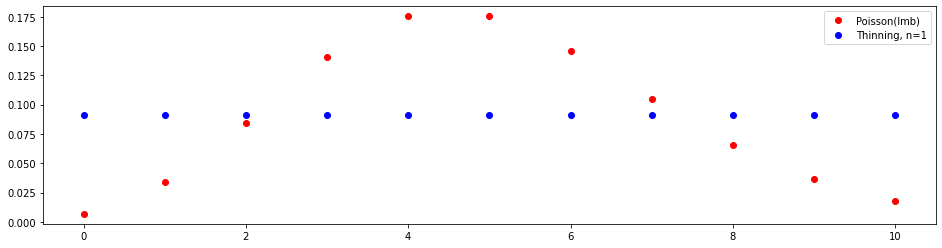

n=2, pmf sum=0.9357109978085472


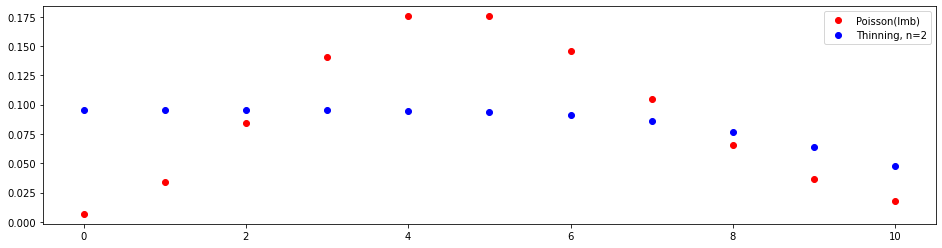

n=3, pmf sum=0.9280701915680059


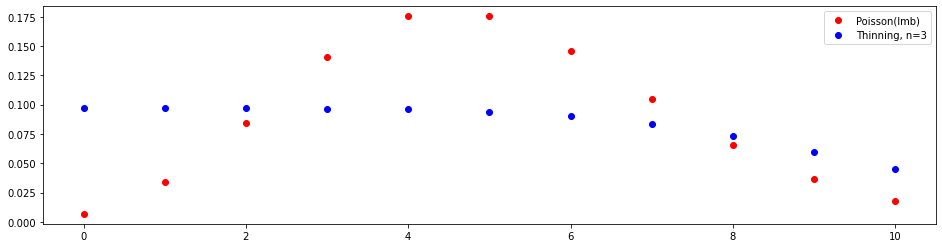

n=4, pmf sum=0.9248135945177055


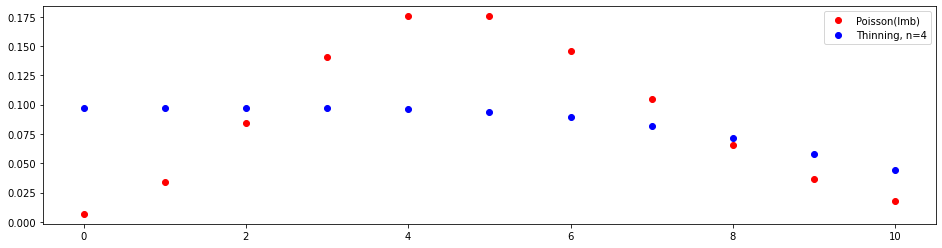

H(Binomial|Poisson) is monotonically decreasing: False (should always be true)
[0.3652805012919636, 0.3133709828661225, 0.31645827416359557, 0.3189221265903468]

H(Binomial) is monotonically increasing: False (should be true only in ULC case)
H(Binomial) is monotonically decreasing: True (should be true only in ULConvex case)
[2.3978952727983707, 2.379994173978512, 2.375501596646919, 2.373335379214681]

H(Binomial)_4=2.373335379214681, H(Poisson(1))=2.146692802738898
H(Binomial|Poisson)=0.3189221265903468

[0.05350517930920879, 0.04380258388707132, 0.04184867466754658, 0.040940351943714905]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



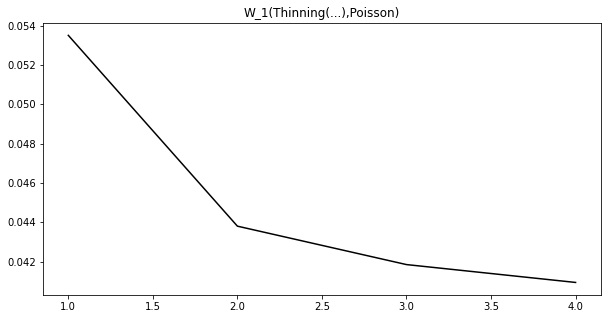

In [427]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 5
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    f = 0
    for j in range(0,l*n+1):
        f+=1/(l*n+1)
    #print(f"uni={f}")
    
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label='Poisson(lmb)')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def renyi_thinning(x, alpha=2):
    # Generate random variables from a Poisson distribution
    n = np.random.poisson(x)

    # Calculate the thinning probability
    p = 1 / (1 + (alpha*(x**2)))

    # Generate a mask for thinning
    mask = np.random.uniform(size=n) < p

    return np.sum(mask)

# Parameters
alpha = 0.5
num_samples = 10000

# Generate samples
samples = [renyi_thinning(10, alpha) for _ in range(num_samples)]

# Calculate PMF
pmf, bins = np.histogram(samples, bins=np.arange(0, max(samples)+2)-0.5, density=True)

print(pmf)
# Plot PMF
plt.bar(bins[:-1], pmf, width=1)
plt.xlabel('Number of Thinned Points')
plt.ylabel('Probability')
plt.title('PMF of Renyi Thinning')
plt.show()

In [372]:
def renyi_thinning(x, alpha):
    # Generate random variables from a Poisson distribution
    n = np.random.poisson(x)

    # Calculate the thinning probability
    p = 1 / (1 + (alpha*(x**2)))

    # Generate a mask for thinning
    mask = np.random.uniform(size=n) < p

    return np.sum(mask)

# Parameters
n = 10
alpha = 1
num_samples = 10000

# Generate samples
samples = [renyi_thinning(10, alpha) for _ in range(num_samples)]
pmf, bins = np.histogram(samples, bins=np.arange(0, max(samples)+2)-0.5, density=True)
print(pmf)

[3.02433333e+00 0.00000000e+00 0.00000000e+00 2.93000000e-01
 0.00000000e+00 0.00000000e+00 1.50000000e-02 0.00000000e+00
 0.00000000e+00 1.00000000e-03]
